##Evaluate the performance of the model using holdout test set 

In [2]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [7]:
# required for Meteor score
!pip install --upgrade nltk
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 1.4MB 8.6MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=4ff8a3217b97f93ad7b6c99d613f7e5d06a19ffb1bf662e87d6885035eb92b50
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
import sys
import os

py_file_location = '/content/drive/MyDrive/ImageCaptioningProject/Notebooks/FinalizedNotebooks'
sys.path.append(os.path.abspath(py_file_location))

import HelperFunctions as helper

In [9]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

def evaluateModel(model, wordtoix, ixtoword, photos, descriptions, max_length):
  actual, predicted = list(), list()
  for key, desc_list in descriptions.items():
    # generate descriptions
    yhat = helper.generateDesc(model, wordtoix, ixtoword, photos[key], max_length)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  return actual, predicted

def getBleuScores(actual, predicted):
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

def getMeteorScore(actual, predicted):
  total_meteor_scores = 0
  for i in range(len(predicted)):
    act_captions = actual[i]
    act_to_str= []
    for act_caption in act_captions:
      act_caption = ' '.join(act_caption)
      act_to_str.append(act_caption)
    pred_caption = ' '.join(predicted[i])
    total_meteor_scores += meteor_score(act_to_str, pred_caption)
  print('METEOR: %f' % (total_meteor_scores/i))

### Loading test dataset

In [10]:
# Load test dataset
descriptions_file = '/content/drive/My Drive/ImageCaptioningProject/descriptions.txt'
features_file = '/content/drive/My Drive/ImageCaptioningProject/features.pkl'

test_image_ids_file = '/content/drive/My Drive/ImageCaptioningProject/Flickr8k_text/Flickr_8k.testImages.txt'
test_ids = helper.loadImageIds(test_image_ids_file)
test_descriptions = helper.loadCleanDescriptions(descriptions_file, test_ids)
test_features = helper.loadImageFeatures(features_file, test_ids)

# Previously defined
max_length = 34

print('Test photos: %d' % len(test_features))

Test photos: 1000


In [11]:
# Loading the previously saved word-to-index dictionary and index-to-word dictionary
wordtoix = load(open('/content/drive/MyDrive/ImageCaptioningProject/FinalizedModels/TextModels/wordtoix.pkl', 'rb'))
ixtoword = load(open('/content/drive/MyDrive/ImageCaptioningProject/FinalizedModels/TextModels/ixtoword.pkl', 'rb'))

model = load_model('/content/drive/MyDrive/ImageCaptioningProject/FinalizedModels/TextModels/model-ep006-loss3.360-val_loss3.612')
actual, predicted = evaluateModel(model, wordtoix, ixtoword, test_features, test_descriptions, max_length)

### Evaluating model

In [24]:
getBleuScores(actual, predicted)
getMeteorScore(actual, predicted)

BLEU-1: 0.529498
BLEU-2: 0.303336
BLEU-3: 0.215750
BLEU-4: 0.106161
METEOR: 0.375847


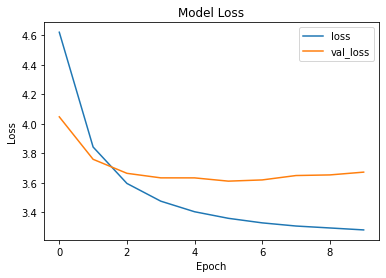

In [25]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
import numpy as np

history = load(open('/content/drive/MyDrive/ImageCaptioningProject/FinalizedModels/TextModels/history', 'rb'))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

### Demonstrate contrast between predicted values vs predicted caption using holdout test set

man in blue shirt is standing on the beach


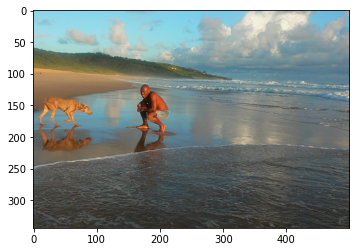

In [44]:
import random

# Getting random test image id
test_id = random.choice(tuple(test_ids))
test_img_feats = test_features[test_id]

# Show test image
image = img.imread('/content/drive/MyDrive/ImageCaptioningProject/Flickr8k_Dataset/' + test_id + '.jpg') 
plt.imshow(image) 

description = helper.generateDesc(model, wordtoix, ixtoword, test_img_feats, max_length)

# Removing start and end flags
print(' '.join(description.split()[1:-1]))